# Computer vision
## Session 02b: Deep Models for computer vision
### Torch DenseNet 

- Animals dataset (5 classes)


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image

from sklearn.metrics import confusion_matrix
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Some basic parameters

inpDir = '/home/dai/directory_env/input' # location where input data is stored
outDir = '/home/dai/directory_env/output' # location to store outputs
subDir = 'train'   # location of the images
modelDir = '/home/dai/directory_env/models'
validDir = 'validation'  # Location of validation files
altName = 'animals_orig'
modelFileName = 'animals_densenet.pth'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

EPOCHS = 10 # number of cycles to run

BATCH_SIZE = 16

ALPHA = 0.001
GAMMA = 0.1

TEST_SIZE = 0.3

# Image Size : The network has an image input size of 224 x 224
IMG_HEIGHT = 224
IMG_WIDTH = 224


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

### Helper Function

In [3]:
def fn_plot_hist(loss, acc):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # create a list of epoch numbers
    epoch_list = list(range(EPOCHS))
                      
    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    
    ax.plot(epoch_list,loss['train'], label = 'Train')
    ax.plot(epoch_list,loss['test'], label = 'test')

    lossmin = min(loss['train'])
    testmin = min(loss['test'])

    # little beautification
    txtstr = "Min Loss: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(lossmin,
                                                                          testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel('Epoch')

    ax.set_ylabel('Loss')

    ax.grid();

    ax = axes[1]

    ax.plot(epoch_list, acc['train'], label = 'Train')
    ax.plot(epoch_list, acc['test'], label = 'test')
    
    # little beautification
    accmax = max(acc['train'])
    testmax = max(acc['test'])
    txtstr = "Max Accuracy: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(accmax,
                                                                                testmax) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epoch")
    ax.set_ylabel('Accuracy')
    ax.grid();
    plt.tight_layout()

In [4]:
data_dir = os.path.join(inpDir,altName, subDir)
data_dir

'/home/dai/directory_env/input/animals_orig/train'

## Load Dataset

Images are under animals/train

     |- butterfly
     |- cow
     |- elephant
     |- sheep
     |- squirrel

In [5]:
# prepare list of subdirectories
print (data_dir)

class_names= [f.path.split('/')[-1] for f in os.scandir(data_dir) if f.is_dir()]

print (class_names)

/home/dai/directory_env/input/animals_orig/train
['scoiattolo_train', 'farfalla_train', 'pecora_train', 'elefante_train', 'mucca_train']


In [6]:
# Sample Size

data_dict = {}

for sDir in class_names:
    data_dict[sDir] = len([os.path.join(data_dir, sDir, imgName) 
                     for imgName in os.listdir(os.path.join(data_dir, sDir))])
    
data_dict

{'scoiattolo_train': 1676,
 'farfalla_train': 1901,
 'pecora_train': 1639,
 'elefante_train': 1302,
 'mucca_train': 1680}

In [7]:
df = pd.DataFrame.from_dict(data_dict.items()).set_index(0).T
df

,scoiattolo_train,farfalla_train,pecora_train,elefante_train,mucca_train
1,1676,1901,1639,1302,1680


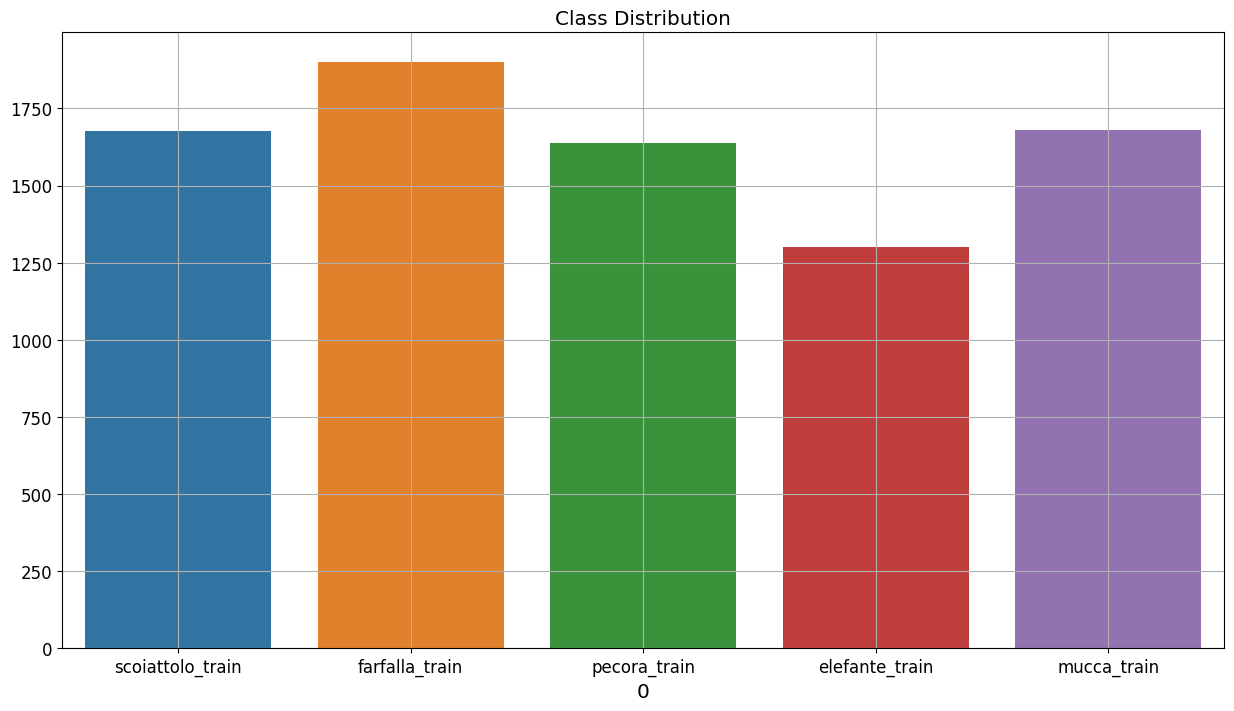

In [8]:
sns.barplot(data=df).set_title('Class Distribution')
plt.grid()
plt.show()

### Data Augmentation Step

In [9]:
transformer = {'tf1': transform.Compose([transform.Resize(255),
                                              transform.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
                                              transform.RandomHorizontalFlip(),
                                              transform.RandomRotation(10),
                                              transform.RandomGrayscale(),
                                              transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                              transform.ToTensor()
                                             ]),
               
               'tf2' : transform.Compose([transform.Resize(255),
                                               transform.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
                                               transform.RandomHorizontalFlip(p=1),
                                               transform.RandomGrayscale(),
                                               transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                               transform.ToTensor()
                                              ]),
               
               'tf3' : transform.Compose([transform.Resize(255),
                                               transform.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
                                               transform.RandomHorizontalFlip(p=0.5),
                                               transform.RandomRotation(15),
                                               transform.RandomGrayscale(p=1),
                                               transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                               transform.ToTensor()
                                              ]),
              }

In [10]:
# uncomment following if you want to augument data

'''dataset1 = ImageFolder(data_dir, 
                       transform=transformer['tf1'])

dataset2 = ImageFolder(data_dir, 
                       transform=transformer['tf2'])

dataset3 = ImageFolder(data_dir, 
                       transform=transformer['tf3'])

dataset = ConcatDataset([dataset1, dataset2, dataset3])'''


dataset = ImageFolder(data_dir, 
                       transform=transformer['tf1'])
len(dataset)

8196

### Is it picking the class names?

In [11]:
# Note : class names cannot be obtained from concatenated dataset
#        Hence, taking from first dataset
class_names = dataset.ctrain_ds, test_ds = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE)
len(train_ds), len(test_ds)lasses
print('total ', len(class_names), class_names)

total  5 ['elefante_train', 'farfalla_train', 'mucca_train', 'pecora_train', 'scoiattolo_train']


### Prepare test and train datasets

In [12]:
train_ds, test_ds = train_test_split(dataset, test_size=TEST_SIZE, random_state=RANDOM_STATE)
len(train_ds), len(test_ds)

(5737, 2459)

In [13]:
batch_size=BATCH_SIZE

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'test':test_dl}
dataset_sizes = {'train':len(train_ds), 'test':len(test_ds)}

### Verify the data
To verify that the dataset looks correct, let's plot a batch from the training set and display the class name below each image.

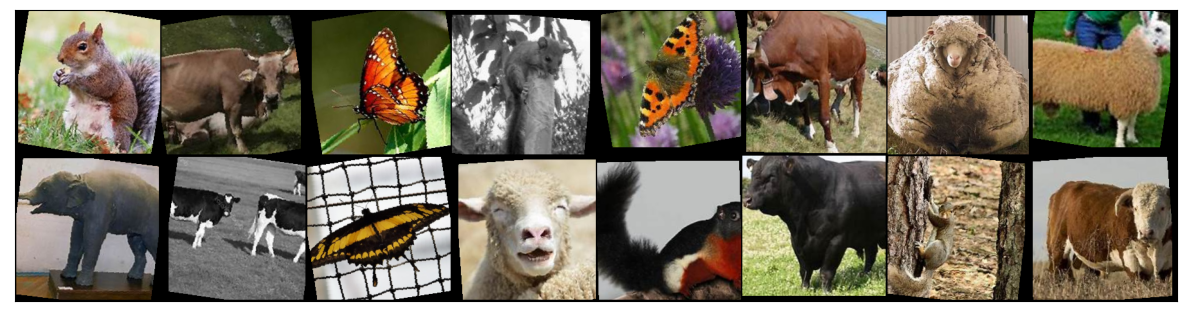

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots()
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0)) 
        # make grid converts them to one image
        # permute to convert to RGB 
        break
        
show_batch(train_dl)

### Accuracy Calculations
Custom accuracy calc to implement on GPU

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [16]:
model = torchvision.models.densenet169(weights='DenseNet169_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/dai/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
42.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


### Freeze existing layer and add one linear layer for classification

In [17]:
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 5)

In [18]:
# Model

In [19]:
# Save losses for future plotting
#save the losses for further visualization

losses = {'train':[], 'test':[]}
accuracies = {'train':[], 'test':[]}


###  Train Function


In [20]:
def train(model, criterion, optimizer, scheduler, epochs):
    
    startTime = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    
    bestAcc = 0.0
    
    for epoch in range(epochs):
        
        for phase in ['train', 'test']:
            
            if phase == 'train':
                
                model.train()
            
            else:
                model.eval()
        
            runningLoss = 0.0
        
            runningCorrects = 0.0
        
            for inputs, labels in loaders[phase]:
            
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                
                    outp = model(inputs)
                
                    _, pred = torch.max(outp, 1)
                
                    loss = criterion(outp, labels)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                runningLoss += loss.item()*inputs.size(0)
            
                runningCorrects += torch.sum(pred == labels.data) 
            
            epochLoss = runningLoss / dataset_sizes[phase]
        
            epochAcc = runningCorrects.double()/dataset_sizes[phase]
        
            losses[phase].append(epochLoss)
            accuracies[phase].append(np.squeeze(epochAcc.data.cpu().numpy())) # accuracy calc is still on GPU

            if phase == 'train':
                
                print('Epoch: {}/{}'.format(epoch+1, epochs))
                
            print('{} - loss:{:.4f}, accuracy:{:.4f}'.format(phase, epochLoss, epochAcc))
            
            if phase == 'test':
                print('Time: {:02d}m {:02d}s'.format(int((time.time()- startTime)//60), 
                                                     int(time.time()- startTime)%60))
            
            if phase == 'test' and epochAcc > bestAcc:
                bestAcc = epochAcc
                best_model = copy.deepcopy(model.state_dict())
    
        scheduler.step()  
    
    elapsedTime = time.time() - startTime
    
    print('Training Time {:02d}m {:02d}s'.format(int(elapsedTime//60), 
                                                 int(elapsedTime%60))) 
    
    print('Best accuracy {:.4f}'.format(bestAcc))
    
    model.load_state_dict(best_model)
    
    return model   

In [21]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.classifier.parameters(), lr = ALPHA)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=GAMMA)

In [22]:
model.to(device)

model = train(model, loss_fn, optimizer, scheduler, EPOCHS)

Epoch: 1/10
train - loss:0.3253, accuracy:0.9062
test - loss:0.1276, accuracy:0.9642
Time: 08m 37s
Epoch: 2/10
train - loss:0.1619, accuracy:0.9463
test - loss:0.1060, accuracy:0.9711
Time: 17m 01s
Epoch: 3/10
train - loss:0.1447, accuracy:0.9496
test - loss:0.0982, accuracy:0.9675
Time: 25m 09s
Epoch: 4/10
train - loss:0.1347, accuracy:0.9526
test - loss:0.0943, accuracy:0.9703
Time: 33m 15s
Epoch: 5/10
train - loss:0.1062, accuracy:0.9634
test - loss:0.0924, accuracy:0.9703
Time: 41m 23s
Epoch: 6/10
train - loss:0.1048, accuracy:0.9634
test - loss:0.0973, accuracy:0.9671
Time: 49m 34s
Epoch: 7/10
train - loss:0.1085, accuracy:0.9623
test - loss:0.0877, accuracy:0.9728
Time: 57m 38s
Epoch: 8/10
train - loss:0.1052, accuracy:0.9625
test - loss:0.0912, accuracy:0.9699
Time: 65m 44s
Epoch: 9/10
train - loss:0.0982, accuracy:0.9672
test - loss:0.0890, accuracy:0.9715
Time: 73m 49s
Epoch: 10/10
train - loss:0.1030, accuracy:0.9658
test - loss:0.0925, accuracy:0.9695
Time: 81m 55s
Training 

In [ ]:
#accuracies['train'] = [np.squeeze(acc.numpy()) for acc in accuracies['train']]
#accuracies['test'] = [np.squeeze(acc.numpy()) for acc in accuracies['test']]

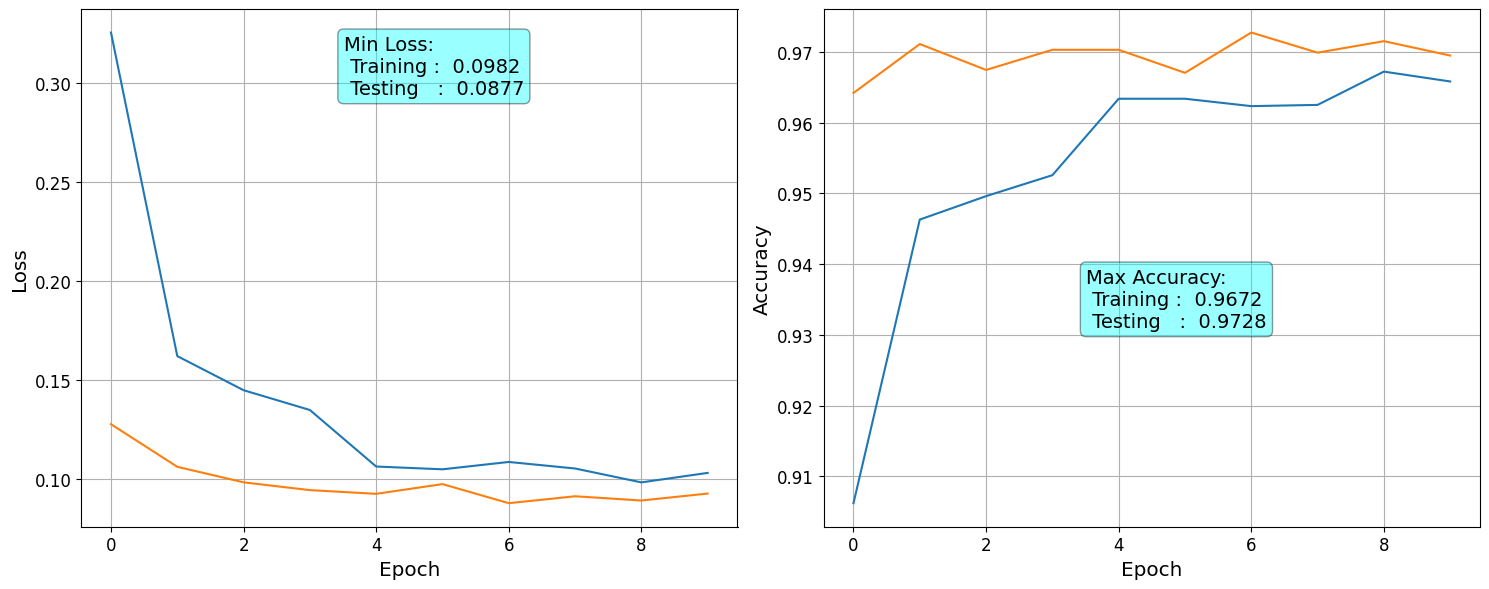

In [23]:
fn_plot_hist(losses, accuracies)

In [24]:
modelPath = os.path.join(modelDir, modelFileName)
torch.save(model, modelPath)

In [25]:
# Model class must be defined somewhere
model1 = torch.load(modelPath)
model1.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Testing

In [31]:
data_transforms = {
    'predict': transform.Compose([transform.Resize(255),
                                  transform.CenterCrop((IMG_HEIGHT, IMG_WIDTH)),
                                  transform.ToTensor()
                                 ])}

dataset = {'predict' : ImageFolder(os.path.join(inpDir, altName, subDir),
                                   data_transforms['predict'])}

dataloader = {'predict': DataLoader(dataset['predict'], 
                                    batch_size = 1, shuffle=False, num_workers=4)}


In [32]:
def visualize_model(model, num_images=32):
    
    # What was the current state of the model
    was_training = model.training
    
    # Eval only
    model.eval()
    
    images_so_far = 0
    
    fig = plt.figure()

    with torch.no_grad(): # not gradient updates
        
        for i, (inputs, labels) in enumerate(dataloader['predict']): # get a set of data (one in this case)
            
            # move to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # get outputs (five logits)
            outputs = model(inputs)
            
            # get predictions
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                
                images_so_far += 1
                
                ax = plt.subplot(num_images//8, 8, images_so_far)
                
                ax.axis('off')
                
                ax.set_title(f'p: {class_names[preds[j]]}')
                
                ax.imshow(inputs.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

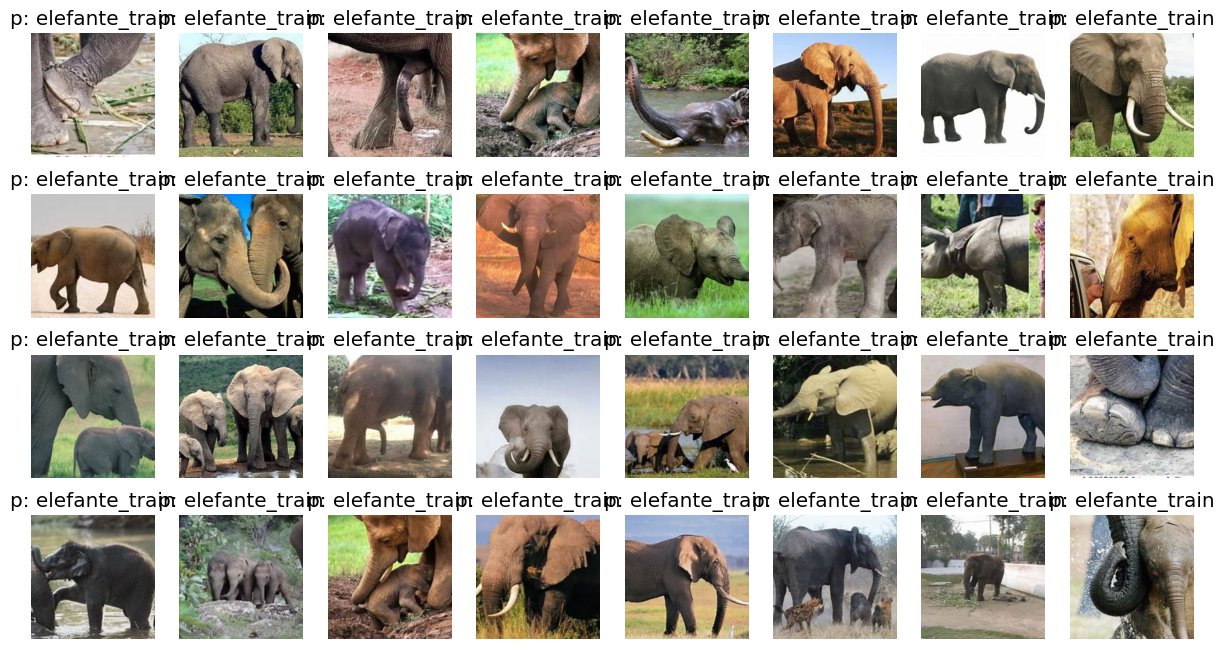

In [33]:
visualize_model(model1)